# Visualize training of AE with representational inertia on dynamic circle/Gaussian data


### training parameters
- Input: sequences of translating circles on Gaussian-blob background (32x32)

- Number of latents: 10

- batch size: 64

- 50K training samples
- RMSprop w lr = 1e-04

- loss: reconstruction loss
- latents are predicted by a weighted (by gamma) sum of the encoder output of the current frame and the latents from the previous time step


``` gamma_values = np.linspace(0, 1, 6) ```


In [1]:
import torch
import pickle
from models import inertiaAE32

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from data.dspritesbT import dSpriteBackgroundDatasetTime

In [2]:
n_latent = 10

gamma_values = np.linspace(0, 1, 6)
print('gammas: ', gamma_values)

gammas:  [0.  0.2 0.4 0.6 0.8 1. ]


In [3]:
vae = list()
training_stats = list()

ng = gamma_values.shape[0]

isTrained = [False]*ng

for jj,gamma in enumerate(gamma_values):

    trainedpath = 'checkpoints/inertiaae32_nlatent=%s_gamma=%s_dsprites_circle_last' % (n_latent,gamma)
    trainstatspath = 'trainstats/inertiaae32_nlatent=%s_gamma=%s_dsprites_circle.pkl' % (n_latent,gamma)

    vae.append(inertiaAE32(n_latent = n_latent))
    training_stats.append([])
    try:
        checkpoint = torch.load(trainedpath)
        vae[jj].load_state_dict(checkpoint['model_states']['net'])
        isTrained[jj] = True
    except:
        print('checkpoint not found: %s' % trainedpath)

    try:
        training_stats[jj] = pickle.load(open(trainstatspath, 'rb'))
        lastone=jj
    except:
        print('trainstats not found: %s' % trainstatspath)

### plot training loss

Three different plots:

- loss = recon_loss + gamma*pred_loss
- recon_loss
- pred_loss

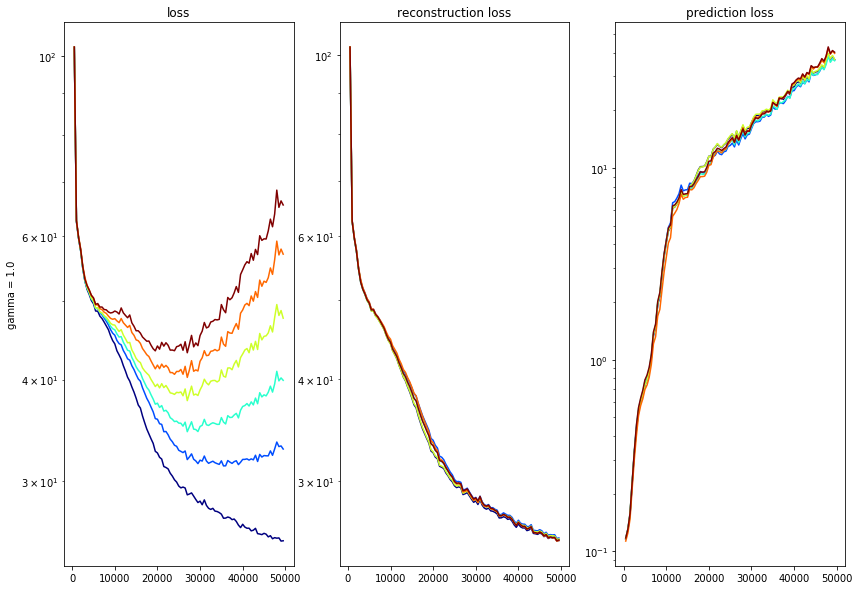

In [4]:
show_until_nth_batch = 200000
idx_lim = np.max(np.where(np.array(training_stats[lastone]['iter']) < show_until_nth_batch))

fig, ax = plt.subplots(1,3,sharey=False,sharex=True, figsize=(14,10))
ax = ax.flatten()

col = plt.cm.jet(np.linspace(0,1,len(gamma_values)))
for jj,gam in enumerate(gamma_values):
    if training_stats[jj]:
        logged_steps = training_stats[jj]['iter'][:idx_lim]
        recon_loss = np.array(training_stats[jj]['recon_loss'][:idx_lim])
        pred_loss = np.array(training_stats[jj]['pred_loss'][:idx_lim])

        ax[0].plot(logged_steps, recon_loss+ gam*pred_loss, color=col[jj])
        ax[1].plot(logged_steps, recon_loss, color=col[jj])
        ax[2].plot(logged_steps, pred_loss, color=col[jj])

        ax[0].set(title='loss')
        ax[1].set(title='reconstruction loss')
        ax[2].set(title='prediction loss')

        _ = [x.set(yscale='log') for x in ax]

#             if jj<1:
#                 ax[2].legend(['betanorm = %0.3f / beta = %0.1f' % (x,y) for x,y in zip(normalized_beta_values,beta)], loc=1)
        ax[0].set(ylabel=('gamma = %s' % gamma_values[jj]))

beta clearly modulates the trade-off between reconstruction and kl-divergence (as expected)


#### plotting reconstruction loss and kl-divergence + prediction loss for each beta value separately

In [5]:
jj=3 # gamma = 1
idx_lim = np.max(np.where(np.array(training_stats[nb*jj]['iter']) < show_until_nth_batch))

fig, ax = plt.subplots(3,2,sharey=False,sharex=True, figsize=(15,15))
ax = ax.flatten()

col = plt.cm.jet(np.linspace(0,1,len(normalized_beta_values)))
ax2 = list()
for ii,_ in enumerate(normalized_beta_values):
    logged_steps = training_stats[nb*jj+ii]['iter'][:idx_lim]
    recon_loss = np.array(training_stats[nb*jj+ii]['recon_loss'][:idx_lim])
    total_kld = np.array(training_stats[nb*jj+ii]['total_kld'][:idx_lim])
    pred_loss = np.array(training_stats[nb*jj+ii]['pred_loss'][:idx_lim])
    
    ax[ii].plot(logged_steps, recon_loss, color='r', label='reconstruction loss')
    ax2.append(ax[ii].twinx())
    ax2[ii].plot(logged_steps, total_kld, color='k', label='kld')
    
    ax2[ii].plot(logged_steps, pred_loss, color='g', label='prediction loss')
    
    ##ax[0].set(ylabel='loss')
    #ax[1].set(ylabel='reconstruction loss')    
    ax[ii].set(ylabel='reconstruction loss')
    ax2[ii].set(ylabel='prediction loss, kl divergence')
    plt.title('betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii]), color=col[ii], 
              fontweight='bold', fontsize = 15)
    
    ax[ii].legend(loc=3)
    ax2[ii].legend(loc=4)
    
fig.tight_layout()

NameError: name 'nb' is not defined

prediction loss tends to track KL-divergence

## load some data and plot reconstructions


In [5]:
ds = dSpriteBackgroundDatasetTime(transform=transforms.Resize(32),shapetype = 'circle')

In [6]:
isTrained

[True, True, True, True, True, True]

/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


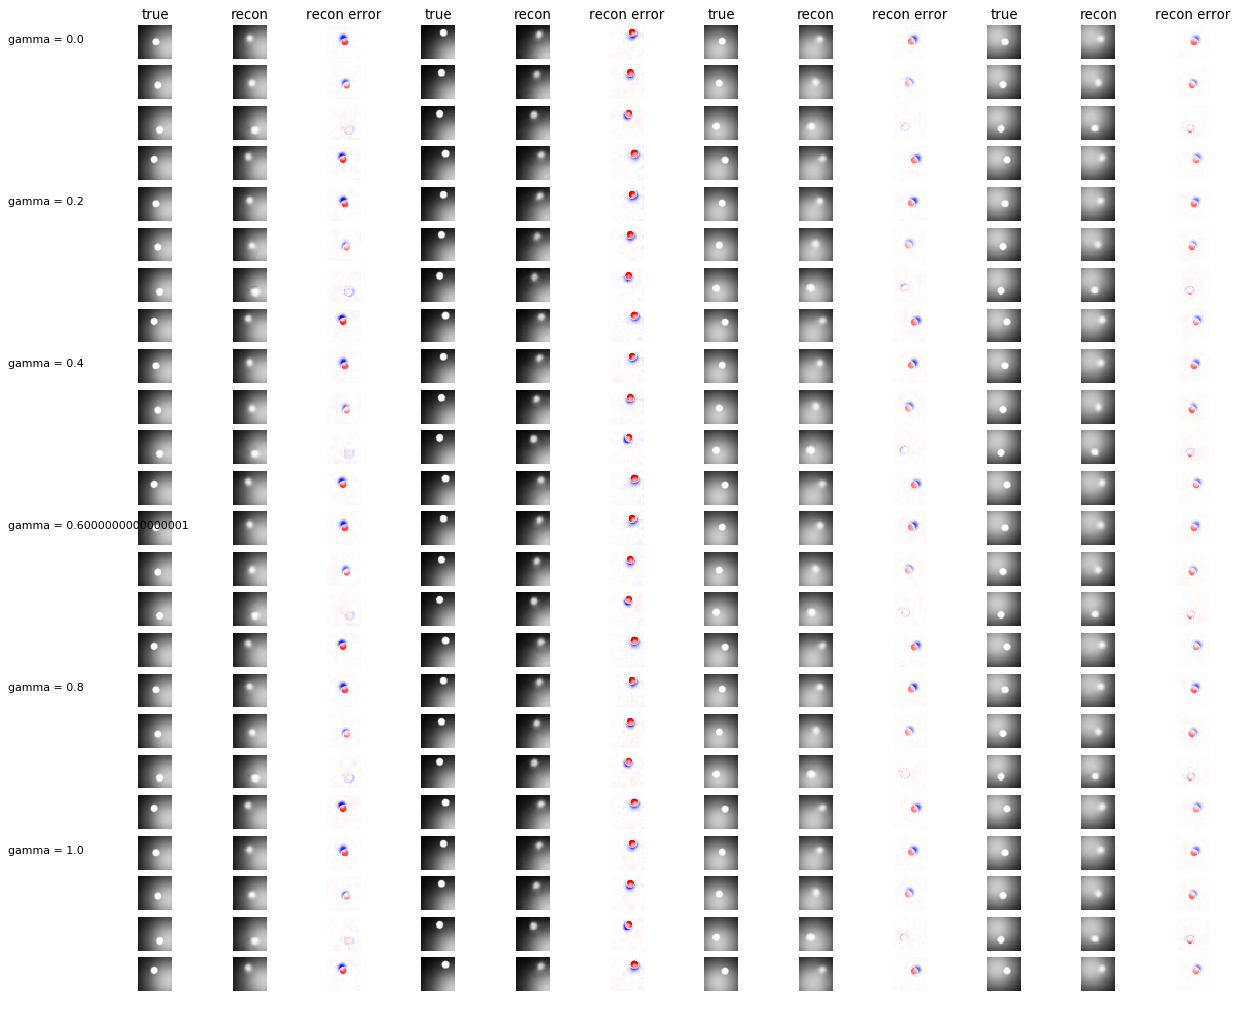

In [7]:
fig, ax = plt.subplots(ng*4,12,figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = ax.flatten()
m = .5
img_idx = np.random.randint(1000, size=4)

for gg,gam in enumerate(gamma_values): # loop across rows (different gamma values)
    if isTrained[gg]:
        for ii in range(4): # loop across different samples

            x,label = ds[img_idx[ii]]
            x = x[np.newaxis, :, :]

            mu,_,_ = vae[gg].encode(x.float())
            recon = vae[gg].decode(mu)[:,1:,:,:,:].detach()
            x = x[:,2:,:,:,:]
            diff = x - recon

            for ff in range(0,4):
                axnum = gg*12*4+(ff-1)*12+ii*3
                plt.set_cmap('gray')
                ax[axnum+0].imshow(x[:,ff*2,:,:,:].squeeze(), vmin=0, vmax=1)
                ax[axnum+0].axis('off')

                ax[axnum+1].imshow(recon[:,ff*2,:,:,:].squeeze(), vmin=0, vmax=1)
                ax[axnum+1].axis('off')

                plt.set_cmap('bwr')
                img = ax[axnum+2].imshow(diff[:,ff*2,:,:,:].numpy().squeeze(), vmin=-m, vmax=m)
                ax[axnum+2].axis('off')

        pos = ax[gg*12*4].get_position()
        fig.text(.05, pos.y0 + pos.height/2, 'gamma = %s' % (gam))

for ii in range(4):
    ax[ii*3+0].set(title='true')
    ax[ii*3+1].set(title='recon')
    ax[ii*3+2].set(title='recon error')


Each row displays the true/reconstructed/error for four samples with one beta.

- Interestingly, with increased beta, the circle object gets lost / is not captured by the VAE any more. 

- At very high beta values, the gaussian background blob is always reconstructed at the same (central) location. This is the case, when q(z|x) is almost equal to p(z), hence indepndent of x. The best "reconstruction" (to minimize reconstruction loss) is the mean image. -> probably, what we see in the high-beta reconstruction case is therefore not a central Gaussian but the average of all circle positions. As circles are constrained to not touch the image borders, this mean image looks like a centered Gaussian.

#### PLOT RECONSTRUCTION ERROR, PREDICTION ERROR

In [8]:
from models import prediction_loss,reconstruction_loss,loss_function

In [9]:
nsamples = 100
pred_loss = np.zeros(shape=(ng,nsamples),dtype=float)
recon_loss = np.zeros(shape=(ng,nsamples),dtype=float)
total_loss = np.zeros(shape=(ng,nsamples),dtype=float)

for ii in range(nsamples): # loop across different samples
    x,_ = ds[ii]
    x = x[np.newaxis, :, :]

    for gg in range(ng):
        recon,mu,mu_enc,mu_pred = vae[gg].forward(x.float())

        pred_loss[gg,ii] = prediction_loss(mu,mu_pred)
        recon_loss[gg,ii] = reconstruction_loss(x,recon)
        total_loss[gg,ii] = loss_function(recon_loss[gg,ii])
    

Text(0.5, 1.0, 'total loss')

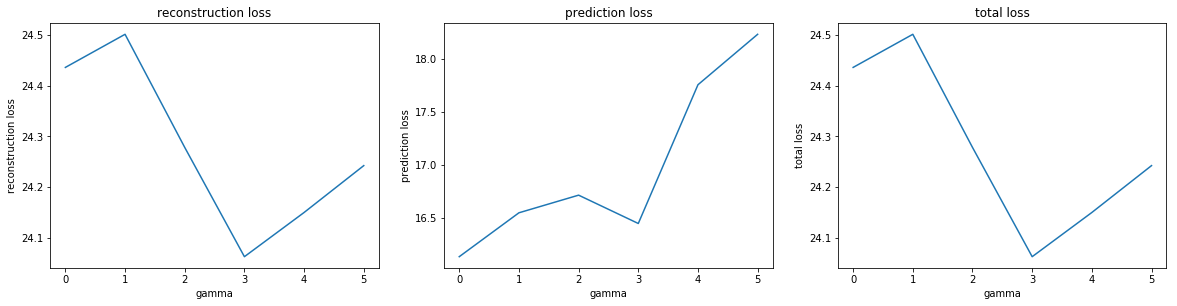

In [10]:
# col = plt.cm.jet(np.linspace(0,1,len(normalized_beta_values)))
fig, ax = plt.subplots(1,3,figsize=(20,4.5))

plt.subplot(1,3,1)
# plt.gca().set_prop_cycle(color=col)
plt.plot(recon_loss.mean(1).T)
# plt.colorbar()
# plt.set_cmap('gray_r')
plt.xlabel('gamma')
plt.ylabel('reconstruction loss')
plt.title('reconstruction loss')

plt.subplot(1,3,2)
# plt.gca().set_prop_cycle(color=col)
plt.plot(pred_loss.mean(1).T)
# plt.colorbar()
# plt.set_cmap('gray_r')
plt.xlabel('gamma')
plt.ylabel('prediction loss')
plt.title('prediction loss')

plt.subplot(1,3,3)
# plt.gca().set_prop_cycle(color=col)
plt.plot(total_loss.mean(1).T)
# plt.colorbar()
# plt.set_cmap('gray_r')
plt.xlabel('gamma')
plt.ylabel('total loss')
plt.title('total loss')

In [11]:
from analyses.analyses import *

Automatic pdb calling has been turned ON


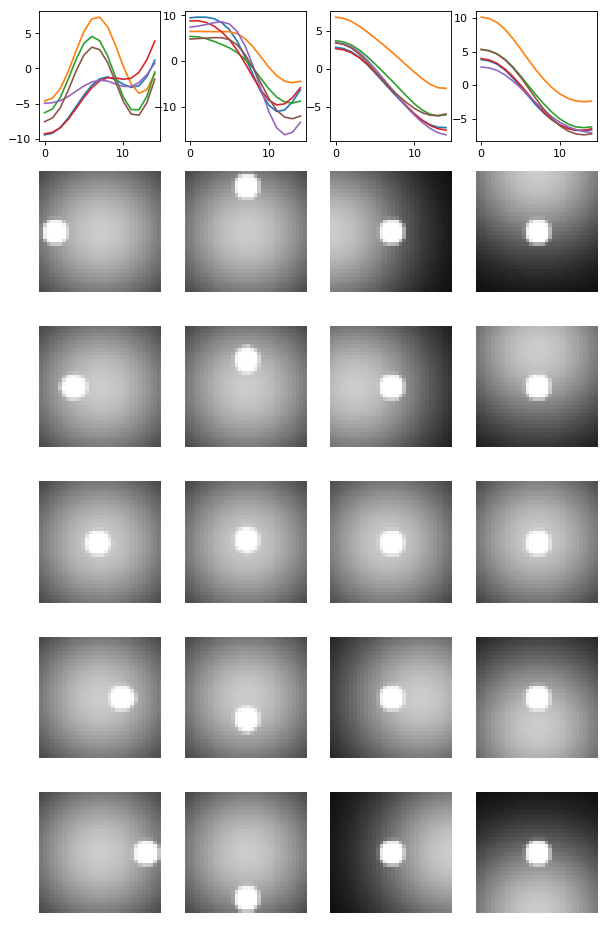

In [12]:
%pdb on
yhat = torch.Tensor(n_latent,15,n_latent,ng)
for gg in range(ng):
    yhat[:,:,:,gg], x_sweep = sweepCircleLatents(vae[gg])#,latents=np.linspace(0,1,10))
_ = plotCircleSweep(yhat[:,:,2], x_sweep)

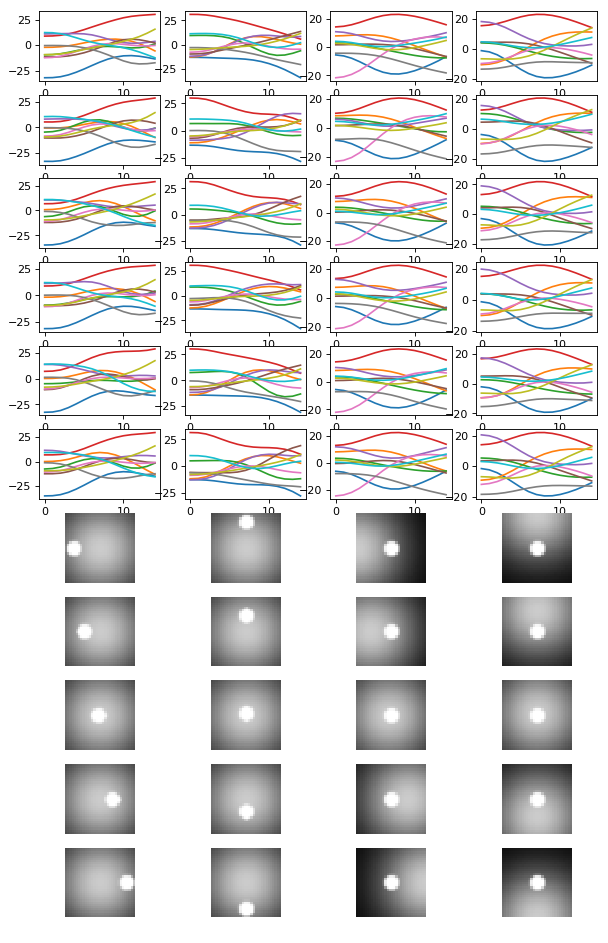

In [13]:
_ = plotCircleSweep(yhat, x_sweep, ng)

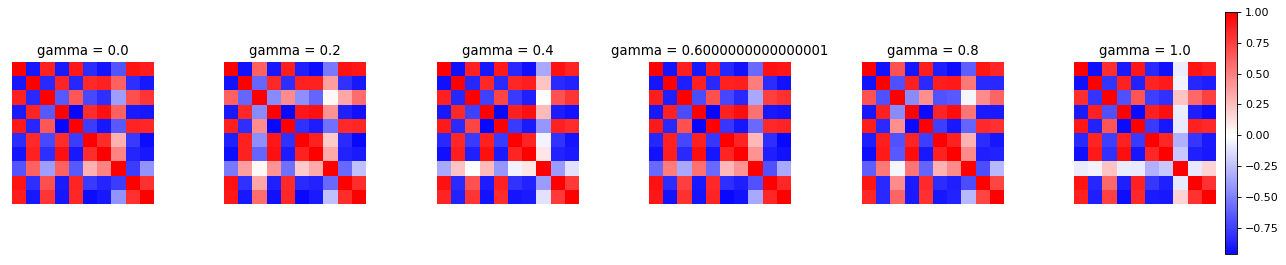

In [14]:
ng=6
mss = np.ndarray(shape=(ng,1),dtype=float)

fig, ax = plt.subplots(ng,1,figsize=(20,4),
                       dpi= 80, facecolor='w', edgecolor='k')
for gg in range(ng):
    plt.subplot(1,ng,gg+1)

    corr_sup = np.corrcoef(yhat[:,:,:,gg].view(-1,n_latent).detach().numpy().T)
    # mean of squared off-diagonal elements
    mss[gg] = np.mean((corr_sup-np.eye(n_latent))**2)

    # Plot covariance
    plt.set_cmap('bwr')
    plt.imshow(corr_sup)
    cb = plt.colorbar()
    colorAxisNormalize(cb)
    ax[gg] = plt.gca()
    ax[gg].axes.get_xaxis().set_ticks([])
    ax[gg].axes.get_yaxis().set_ticks([])
    plt.box(False)
    if gg is not ng-1:
        cb.remove()
    plt.title('gamma = %s' % gamma_values[gg])


Text(0.5, 1.0, 'mean squared cross-correlations')

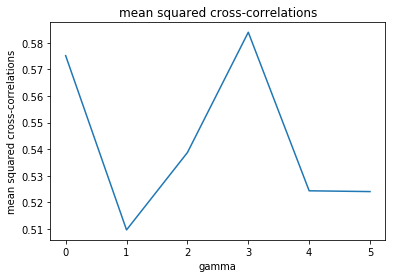

In [15]:
plt.plot(mss)
plt.ylabel('mean squared cross-correlations')
plt.xlabel('gamma')
plt.title('mean squared cross-correlations')

Our finding from our experiments on classic $\beta$-VAE holds: increasing entanglement with increasing $\beta$. At a glance, $\gamma$ near 1 appears to further disentangle at low $\beta$, but this might not be significant.

### Generate synthetic z's, decode/reconstruct them

In [16]:
mins,_ = yhat.view(-1,n_latent,ng).min(0)
maxs,_ = yhat.view(-1,n_latent,ng).max(0)
means = yhat.view(-1,n_latent,ng).mean(0)
mins,means,maxs,means.shape

(tensor([[-34.0814, -33.1840, -34.8259, -33.4518, -32.5961, -35.1086],
         [-17.9144, -19.2039, -20.0295, -19.1310, -21.4444, -21.6963],
         [-10.9782,  -4.6754,  -9.1286,  -9.5286, -16.0609, -12.5456],
         [ -5.7545,  -7.4100,  -6.3912,  -6.6244,  -4.4325,  -6.2563],
         [-11.8531,  -8.8041, -12.8450,  -9.1018, -11.8243, -12.9597],
         [-14.2437, -15.8607, -15.6328, -15.0069, -15.5698, -16.8316],
         [-26.3479, -28.7222, -29.5498, -28.0205, -30.1372, -30.9778],
         [-20.4655, -21.1546, -21.4353, -22.7312, -20.6724, -23.2984],
         [ -9.2471,  -9.3692,  -9.6144,  -9.6085,  -8.2866,  -9.4128],
         [-12.2630,  -9.6048, -15.0490, -10.2611, -12.4621, -15.5968]],
        grad_fn=<MinBackward0>),
 tensor([[  5.9216,   4.5412,   4.6918,   5.6130,   7.5730,   5.1561],
         [-10.0442, -10.8296, -10.8230, -10.6529, -11.9633, -11.9477],
         [  3.4629,   4.1842,   3.8158,   3.7377,   1.2717,   2.6497],
         [  4.4412,   2.4357,   3.5110,   3

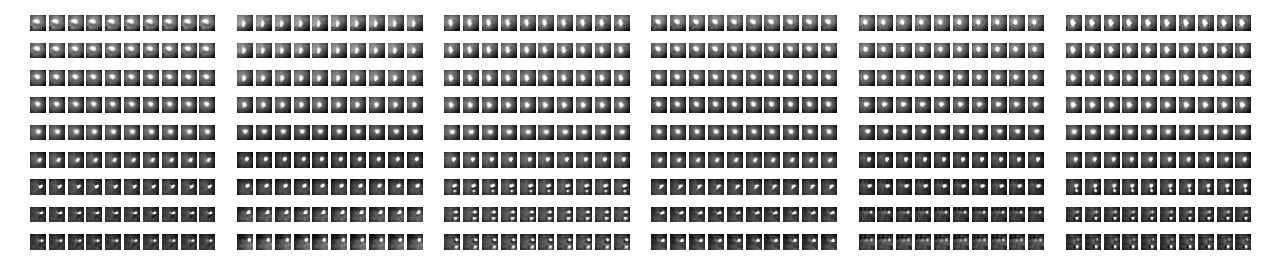

In [19]:
n_frames = 9

# z.shape,recon.shape,z
fig, ax = plt.subplots(n_frames,(n_latent+1)*ng,figsize=(20,4),
                       dpi= 80, facecolor='w', edgecolor='k')

for gg in range(0,ng):
    z = means[:,gg].repeat(n_frames,1).t()

    for ll in range(0,n_latent):
        z[ll,:] = torch.linspace(mins[ll,gg].detach(),maxs[ll,gg].detach(),n_frames)
    recon = vae[gg].decode(z.t())
    for ll in range(0,n_latent):
        plt.set_cmap('gray')
        for ff in range(0,n_frames):
            plt.subplot(n_frames,(n_latent+1)*ng,((n_latent+1)*ng)*ff+(n_latent+1)*gg+ll+1)
            plt.imshow(recon[:,ff,:,:,:].detach().squeeze())
            plt.axis('off')
    for ff in range(0,n_frames):
        plt.subplot(n_frames,(n_latent+1)*ng,((n_latent+1)*ng)*ff+(n_latent+1)*gg+n_latent+1)
        plt.axis('off')